# Writing data to and reading data from a Database using Python

## Libraries and settings

In [11]:
# Libraries
import os
import sqlite3
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Function to close a sqlite db-connection
def check_conn(conn):
     try:
        conn.cursor()
        return True
     except Exception as ex:
        return False

# Get current working directory
print(os.getcwd())

/workspaces/applied_research_methods/Week_02/Data


In [12]:
# adjust the path if your file sits elsewhere
df = pd.read_json('/workspaces/applied_research_methods/Week_02/Data/supermarkets.json')

print(df.shape)
df.head()


(3392, 5)


,type,id,lat,lon,tags
0,node,33126515,47.155616,9.037915,"{'brand': 'Spar', 'brand:wikidata': 'Q610492',..."
1,node,36726161,47.226191,8.980329,"{'addr:city': 'Uznach', 'addr:housenumber': '2..."
2,node,39768209,47.225069,8.969981,"{'addr:city': 'Uznach', 'addr:postcode': '8730..."
3,node,39947904,47.376732,8.542161,"{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
4,node,48932835,47.375020,8.522895,"{'addr:city': 'Zürich', 'addr:housenumber': '7..."


In [15]:
# Expand 'tags' dictionary into separate columns
tags_expanded = pd.json_normalize(df['tags'])

# Combine with the other columns
df_flat = pd.concat([df.drop(columns=['tags']), tags_expanded], axis=1)
# Remove duplicate columns if any (keep first occurrence)
df_flat = df_flat.loc[:, ~df_flat.columns.duplicated()]

# Preview
print(df_flat.shape)
df_flat.head()


(3392, 236)


,type,id,lat,lon,brand,brand:wikidata,brand:wikipedia,name,opening_hours,shop,...,source:addr,opening_date,postid,operator:website,diet:local,payment:account_cards,diet:fish,diet:mediterranean,diet:organic,diet:seafood
0,node,33126515,47.155616,9.037915,Spar,Q610492,en:SPAR (retailer),Spar,Mo-Th 08:00-19:00; Fr 08:00-20:00; Sa 08:00-17:00,supermarket,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,36726161,47.226191,8.980329,Migros,Q680727,de:Migros,Migros,"Mo-Th 08:00-19:00, Fr 08:00-20:00, Sa 07:30-17...",supermarket,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,39768209,47.225069,8.969981,Coop,Q432564,NaN,Coop,NaN,supermarket,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,39947904,47.376732,8.542161,Coop,Q432564,de:Coop (Schweiz),Coop,Mo-Sa 06:00-22:00,supermarket,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,48932835,47.375020,8.522895,Migros,Q680727,NaN,Migros,Mo-Sa 08:00-21:00; PH off,supermarket,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create sqlite data base

In [16]:
# Create SQLite database
conn = sqlite3.connect('/workspaces/applied_research_methods/Week_02/Data/supermarkets_database.db')

# Write the flattened DataFrame to SQL
df_flat.to_sql('supermarkets_table', conn, if_exists='replace', index=False)

# Check number of rows written
row_count = pd.read_sql_query("SELECT COUNT(*) AS n FROM supermarkets_table", conn)
row_count




,n
0,3392


## Create SQL-table in the database

In [16]:
cursor.execute('''CREATE TABLE IF NOT EXISTS apartments_table (OrderId VARCHAR(50),
                                                               Adress VARCHAR(200),
                                                               Rooms DECIMAL(8,2),
                                                               Area INT(8),
                                                               Price DECIMAL(8,2))''')
# Confirm changes to the table
conn.commit()

## Read data from file to data frame

In [17]:
df = pd.read_csv('/workspaces/applied_research_methods/Week_02/Data/apartments_data_prepared.csv',
                  sep=',', 
                  encoding='utf-8')[['web-scraper-order', 'address_raw', 'rooms', 'area', 'price']]
print(df.shape)
df.head(5)

(1008, 5)


,web-scraper-order,address_raw,rooms,area,price
0,1693998201-1,"Neuhusstrasse 6, 8630 Rüti ZH, ZH",3.0,49.0,1441.0
1,1693998201-2,"Zürcherstrasse 1, 8173 Neerach, ZH",3.5,65.0,1850.0
2,1693998201-3,"Cramerstrasse 8-12, 8004 Zürich, ZH",NaN,NaN,2686.0
3,1693998201-4,"Cramerstrasse 8-12, 8004 Zürich, ZH",2.0,54.0,4853.0
4,1693998201-5,"Rotachstrasse 33, 8003 Zürich, ZH",2.0,49.0,4335.0


## Write data to the SQL-table in data base

In [18]:
df.to_sql(name = 'apartments_table',
          con = conn,
          index = False,
          if_exists = 'replace')

1008

## Query the SQL-table

In [17]:
# Query the SQL-table
cursor.execute('''SELECT *
               FROM apartments_table
               WHERE rooms >=1''')

df = pd.DataFrame(cursor.fetchall(), 
                  columns=['OrderId','Address','Rooms','Area','Price'])    
df

NameError: name 'cursor' is not defined

## Plot histogramm of rental prices

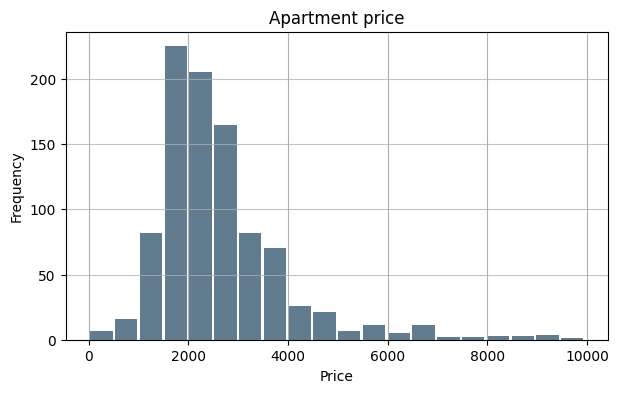

In [20]:
# Create a histogram
plt.figure(figsize=(7,4))
df.Price.plot.hist(grid=True, 
                   bins=20, 
                   rwidth=0.9,
                   color='#607c8e')
plt.title('Apartment price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

## Close db connection (if open)

In [ ]:
# Close db connection (if open)
try:
    if check_conn(conn):
        conn.close()
    else:
        pass
        {
            "cell_type": "code",
            "id": "#VSC-f64eef6a",
            "metadata": {
                "language": "python"
            },
            "source": [
                "# Create SQLite database",
                "conn = sqlite3.connect('/workspaces/applied_research_methods/Week_02/Data/supermarkets_database.db')",
                "",
                "# Create cursor object to execute SQL commands",
                "cursor = conn.cursor()",
                "",
                "# Write the flattened DataFrame to SQL",
                "df_flat.to_sql('supermarkets_table', conn, if_exists='replace', index=False)",
                "",
                "# Check number of rows written",
                "row_count = pd.read_sql_query(\"SELECT COUNT(*) AS n FROM supermarkets_table\", conn)",
                "row_count",
                "",
                "",
                ""
            ]
        },
print('-----------------------------------')

False


In [24]:
# Additional SQL-queries
# Filter apartments with ≥ 4 rooms and area ≥ 100 m²
cursor.execute('''SELECT *
               FROM apartments_table
               WHERE rooms >=4 AND area >=100''')

In [25]:
# Calculate average price per room size
cursor.execute('''
SELECT rooms, AVG(price) AS avg_price
FROM apartments_table
GROUP BY rooms
''')

# Fetch results
results = cursor.fetchall()

# Print a preview
for row in results[:10]:
    print(row)


(None, 3250.8444444444444)
(1.0, 1290.311475409836)
(1.5, 2036.4186046511627)
(2.0, 2133.375)
(2.5, 2450.9074074074074)
(3.0, 2112.0178571428573)
(3.5, 2643.3709677419356)
(4.0, 2890.2571428571428)
(4.5, 3029.4329896907216)
(5.0, 2993.3333333333335)


In [26]:
# Calculate average area per room size
cursor.execute('''
SELECT rooms, AVG(area) AS avg_area
FROM apartments_table
GROUP BY rooms
''')

results_area = cursor.fetchall()

df_avg_area = pd.DataFrame(results_area, columns=['rooms', 'avg_area'])
df_avg_area.head()


,rooms,avg_area
0,NaN,NaN
1,1.0,32.092593
2,1.5,35.526316
3,2.0,54.428571
4,2.5,67.317881
